# Stacking Classifier

In [1]:
from common import get_prediction, split_data, get_data
import preprocessing as prep
import numpy as np

## Cargamos el dataset

In [2]:
data = get_data()
data.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


In [3]:
pred = get_prediction()
pred.head()

0    0
1    0
2    0
3    0
4    1
Name: volveria, dtype: int64

## Dividimos los datos

Separamos un validation para los modelos

In [4]:
X_train_val, X_val_2, y_train_val, y_val_2 = split_data(data, pred)
X_train_val.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
239,normal,Señor Celestino Miguel,797,mujer,52.0,0,0,39687,3,adelante,fiumark_palermo
281,4d,Señora Reina Benita,141,mujer,NaN,0,2,489:,2,NaN,fiumark_chacarita
504,3d,Señor Emeterio de Jesus,309,hombre,33.0,1,0,"R1RR""55:3",3,NaN,fiumark_chacarita
230,4d,Señor Juan Jorge Alberto,158,hombre,33.0,0,0,"UQVQP1QS""5;42;2",1,NaN,fiumark_palermo
738,4d,Señor Pablo Augusto,495,hombre,24.0,0,0,"C16""675:2",1,NaN,fiumark_palermo


Separamos otro validation para elegir el mejor modelo en una familia de modelos con el mejor preprocesado

In [5]:
X_train, X_val, y_train, y_val = split_data(X_train_val, y_train_val)
X_train.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
475,4d,Señor Ignacio Nazar,689,hombre,21.0,0,0,572258,1,NaN,fiumark_palermo
247,4d,Señor Abel Omar,644,hombre,NaN,0,0,3823,6,NaN,fiumark_palermo
726,normal,Señor Fausto Rene,468,hombre,59.0,0,0,3359;4,3,NaN,fiumark_palermo
106,3d,Señora Irma Pascualina,707,mujer,48.0,0,0,4457;8,2,NaN,fiumark_palermo
206,4d,Señor Ovidio Valentin,871,hombre,29.0,0,0,56;46:,1,NaN,fiumark_palermo


## Entrenamos los modelos

Esta vez entrenaremos los mejores modelos con lo mejores preprocesados obtenidos en los notebooks anteriores.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

### Stacking con Tree, knn, NB y SVM
Primero probamos con los 3 modelos mas basicos:
1. Decision Tree Classifier
1. K Neighbors Classifier
1. Gaussian y Multinomial Naive Bayes 
1. Support Vector Classifier

Definimos los modelos

In [7]:
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=7, random_state=20)

knn = KNeighborsClassifier(metric='euclidean', n_neighbors=12)

mnb = MultinomialNB()

gnb = GaussianNB()

svc = SVC(
    C=6, coef0=1, degree=2.7, gamma=0.5, kernel='poly'
)

Preparamos los preprocesados

In [8]:
list_preprocessing = [
        prep.Preprocessing_Tree_Bagging(), 
        prep.Preprocessing_KNN_SVM(),
        prep.Preprocessing_NB_Boosting_Stacking()
    ]

Primero con el multinomial

In [9]:
clf_1 = tree
clf_2 = knn
clf_3 = mnb
clf_4 = svc
stacking_model = StackingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3), ('clf_4', clf_4)],
    cv=5, n_jobs=-1
)

Preprocesamos y entrenamos

In [10]:
from common import training

models_preprocessing_1 = training(
    stacking_model, X_train, y_train, list_preprocessing
)

Ahora con el gaussian

In [11]:
clf_1 = tree
clf_2 = knn
clf_3 = gnb
clf_4 = svc
stacking_model = StackingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3), ('clf_4', clf_4)],
    cv=5, n_jobs=-1
)

Preprocesamos y entrenamos

In [12]:
models_preprocessing_2 = training(
    stacking_model, X_train, y_train, list_preprocessing
)

Unimos las listas

In [13]:
models_preprocessing = models_preprocessing_1 + models_preprocessing_2

Obtenemos las predicciones

In [14]:
from common import get_proba_predicts

proba_predictions = get_proba_predicts(models_preprocessing, X_val)

Comparamos los distintos modelos mediante la curva auc roc.

<Figure size 432x288 with 0 Axes>

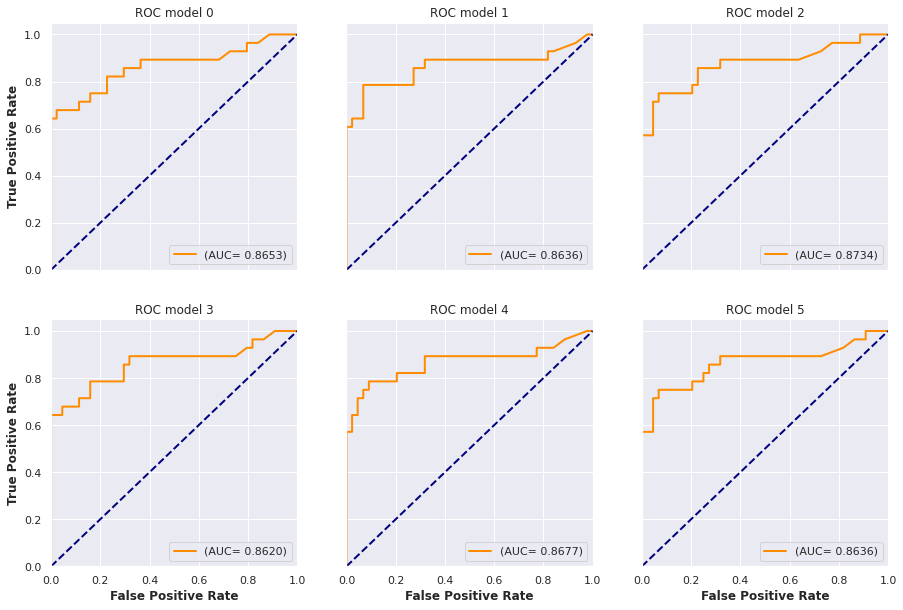

In [15]:
from common import plot_rocs

best_model_index = plot_rocs(proba_predictions, y_val, 3, 2)

Escogemos el mejor modelo, que en este caso es el 2

In [16]:
best_model_stacking_1 = models_preprocessing[best_model_index]
best_model_stacking_1[0]

StackingClassifier(cv=5,
                   estimators=[('clf_1',
                                DecisionTreeClassifier(max_depth=5,
                                                       min_samples_leaf=7,
                                                       random_state=20)),
                               ('clf_2',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=12)),
                               ('clf_3', MultinomialNB()),
                               ('clf_4',
                                SVC(C=6, coef0=1, degree=2.7, gamma=0.5,
                                    kernel='poly'))],
                   n_jobs=-1)

Con el siguiente preprocesado

In [17]:
best_model_stacking_1[1].function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la moda


### Stacking con Bagging, RF y Boosting
Ahora probamos los modelos mas potentes:
1. Bagging Classifier
1. Random Forest Classifier
1. Gradient Boosting Classifier

Definimos los modelos

In [18]:
bc = BaggingClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=5,random_state=20),
    n_estimators=29, n_jobs=-1, random_state=20
)

rfc = RandomForestClassifier(
    criterion='entropy', max_depth=6, min_samples_leaf=3,
    n_estimators=14, n_jobs=-1, random_state=20
)

gbc = GradientBoostingClassifier(
    learning_rate=0.01, max_depth=4, min_samples_leaf=2,
    n_estimators=338, random_state=20
)

Preparamos los preprocesados

In [19]:
list_preprocessing = [
        prep.Preprocessing_Tree_Bagging(), 
        prep.Preprocessing_NB_Boosting_Stacking(),
        prep.Preprocessing_RF()
    ]

Preparamos el modelo stacking

In [20]:
clf_1 = bc
clf_2 = rfc
clf_3 = gbc
stacking_model = StackingClassifier(
    estimators=[('clf_1', clf_1), ('clf_2', clf_2), ('clf_3', clf_3)],
    cv=5, n_jobs=-1
)

Preprocesamos y entrenamos

In [21]:
models_preprocessing = training(
    stacking_model, X_train, y_train, list_preprocessing
)

Obtenemos las predicciones

In [22]:
from common import get_proba_predicts

proba_predictions = get_proba_predicts(models_preprocessing, X_val)

Comparamos los distintos modelos mediante la curva auc roc.

<Figure size 432x288 with 0 Axes>

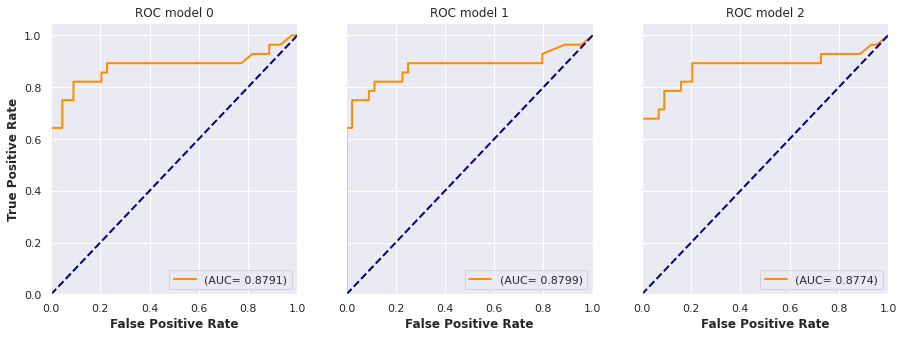

In [23]:
from common import plot_rocs

best_model_index = plot_rocs(proba_predictions, y_val, 3, 1)

Escogemos el mejor modelo, que en este caso es el 1

In [24]:
best_model_stacking_2 = models_preprocessing[best_model_index]
best_model_stacking_2[0]

StackingClassifier(cv=5,
                   estimators=[('clf_1',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                        random_state=20),
                                                  n_estimators=29, n_jobs=-1,
                                                  random_state=20)),
                               ('clf_2',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=3,
                                                       n_estimators=14,
                                                       n_jobs=-1,
                                                       random_state=20)),
                               ('clf_3',
                                GradientBoostingClassifier(learning

Con el siguiente preprocesado

In [25]:
best_model_stacking_2[1].function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la moda


## Escogemos el mejor modelo

In [26]:
models_prep_final = [best_model_stacking_1, best_model_stacking_2]

proba_predicts = get_proba_predicts(models_prep_final, X_val)

<Figure size 432x288 with 0 Axes>

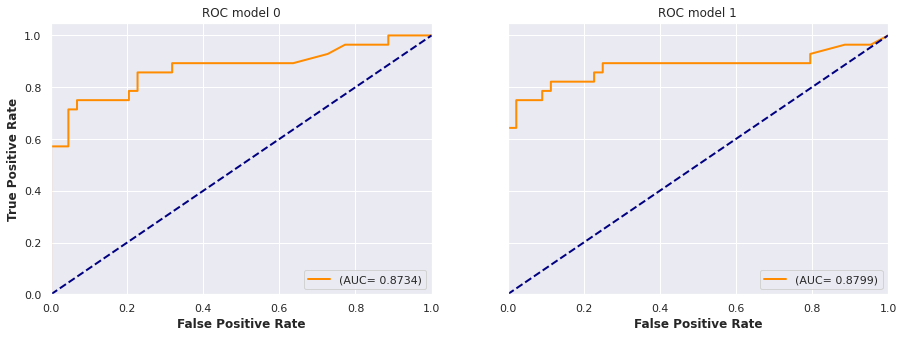

In [27]:
best_model_index = plot_rocs(proba_predicts, y_val, 2, 1)

El mejor modelo de todos resultó ser ultimo modelo.

In [28]:
best_stacking, preprocessing = models_prep_final[best_model_index]
best_stacking

StackingClassifier(cv=5,
                   estimators=[('clf_1',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                                                        random_state=20),
                                                  n_estimators=29, n_jobs=-1,
                                                  random_state=20)),
                               ('clf_2',
                                RandomForestClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=3,
                                                       n_estimators=14,
                                                       n_jobs=-1,
                                                       random_state=20)),
                               ('clf_3',
                                GradientBoostingClassifier(learning

Con el siguiente preprocesado.

In [29]:
preprocessing.function()

Elimina las columnas con alta cardinalidad
Elimina las columnas con un porcentaje de valores nan mayor igual al 70%
Transforma las variables categoricas en dummy variables
Rellena los nan de edad con la moda


## Vemos las metricas del mejor modelo

Preprocesamos los datos

In [30]:
X_val_2_ = preprocessing.transform(X_val_2)
X_val_2_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
713,24.0,0,1,8,0,1,0,1,0,0
370,22.0,0,0,1,1,0,0,1,0,0
114,35.5,1,0,3,0,0,0,0,0,0
323,22.0,0,0,1,1,0,1,0,1,0
131,7.0,0,2,3,1,0,1,1,0,0


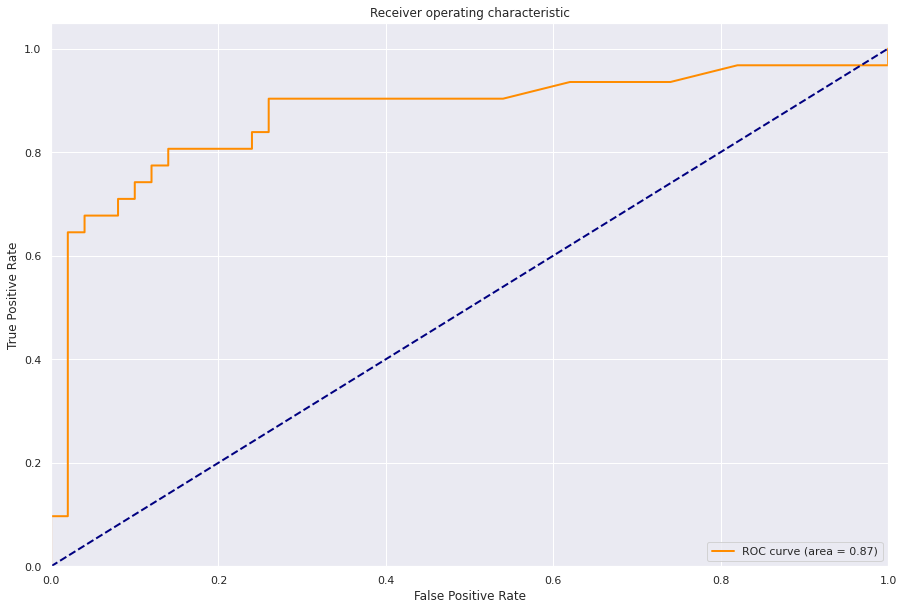

0.8729032258064515

In [31]:
from common import plot_roc
plot_roc(y_val_2, best_stacking.predict_proba(X_val_2_)[:,1])

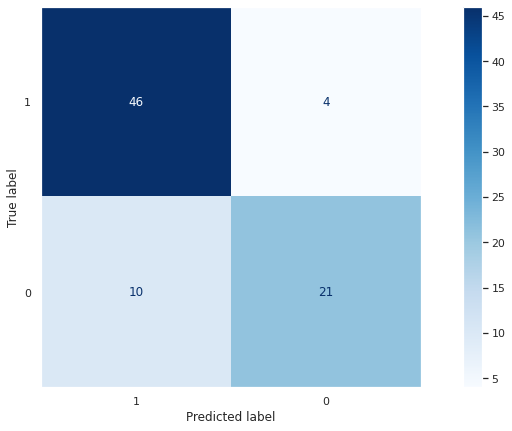

In [32]:
from common import plot_confusion
plot_confusion(
    best_stacking, 
    X_val_2_, 
    y_val_2
)

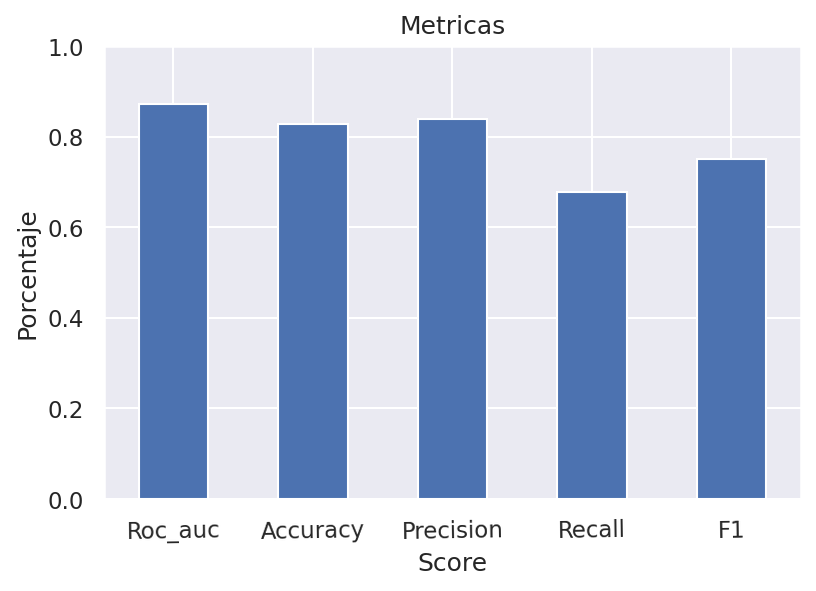

Roc_auc      0.872903
Accuracy     0.827160
Precision    0.840000
Recall       0.677419
F1           0.750000
dtype: float64

In [33]:
from common import plot_metrics
plot_metrics(
    y_val_2, 
    best_stacking.predict_proba(X_val_2_)[:,1], 
    best_stacking.predict(X_val_2_)
)

# Hacemos la predicción sobre el holdout de la empresa

In [35]:
from common import get_holdout
X_holdout_empresa = get_holdout()
X_holdout_empresa.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señorita Beatriz Estela,650,mujer,26.0,0,0,"EC0""4536",1,NaN,fiumark_palermo
1,4d,Señorita Elena Herminda,234,mujer,8.0,4,2,569299,4,NaN,fiumark_palermo
2,normal,Señor Humberto Americo,31,hombre,43.0,0,0,"RE""39823",3,NaN,fiumark_chacarita
3,3d,Señor Casiano,552,hombre,30.0,0,0,46657:,3,NaN,fiumark_palermo
4,4d,Señor Gregorio Nicolas,411,hombre,NaN,0,0,56;444,1,NaN,fiumark_palermo


Preprocesamos el holdout de la empresa con el mejor preprocesamiento para este modelo y separamos 

In [36]:
ussers = X_holdout_empresa['id_usuario']
p = prep.Preprocessing_NB_Boosting_Stacking()
p.fit(X_train)
X_holdout_empresa_ = p.transform(X_holdout_empresa)
X_holdout_empresa_.head()

,edad,amigos,parientes,precio_ticket,tipo_de_sala_4d,tipo_de_sala_normal,genero_mujer,nombre_sede_fiumark_palermo,nombre_sede_fiumark_quilmes,nombre_sede_nan
0,26.0,0,0,1,1,0,1,1,0,0
1,8.0,4,2,4,1,0,1,1,0,0
2,43.0,0,0,3,0,1,0,0,0,0
3,30.0,0,0,3,0,0,0,1,0,0
4,25.0,0,0,1,1,0,0,1,0,0


Predecimos con el mejor modelo

In [37]:
volveria = best_stacking.predict(X_holdout_empresa_)
volveria

array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0])

Generamos el dataframe de las predicciones

In [38]:
import pandas as pd
predictions = pd.DataFrame({
    'id_usuario': ussers, 
    'volveria': volveria
})
predictions.head()

,id_usuario,volveria
0,650,0
1,234,0
2,31,1
3,552,0
4,411,0


Guardamos el archivo

In [39]:
predictions.to_csv(
    'Stacking.csv', 
    columns=predictions.columns, 
    index=False
)